# Modelos: Comparativas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'
DATASET_PATH          = f'{BASE_PATH}/datasets'
WEIGHTS_PATH          = f'{BASE_PATH}/weights'
STACKING_PATH         = f'{DATASET_PATH}/stacking'

METRICS_PATH          = f'{BASE_PATH}/metrics/stacking'

MODELS = [
    'cb_user_profile',
    'knn_user',
    'knn_item',
    'knn_ensemble',
    'gmf',
    'biased_gmf', 
    'nnmf',
    'deep_fm'
] 

In [3]:
import sys
sys.path.append(LIB_PATH)

import torch
from torch.nn import Sigmoid, ReLU
from torch.optim import SparseAdam, Adam
from torch.utils.data import Dataset, DataLoader

from torchmetrics import R2Score
from torch.nn import MSELoss

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter


import data as dt
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import numpy as np
import pandas as pd

import model as ml
import data.plot as pl

import util as ut

from bunch import Bunch

2023-11-07 22:02:52.738827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 22:02:53.263054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-07 22:02:53.528066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 22:02:53.539866: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.0.1+cu118'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

## Helper Functions

In [8]:
def load_dataset(path, models, post_fix):
    datasets = []
    for model in MODELS:
        ds = ut.load_df(f'{path}/{model}_{post_fix}.json')
        ds['model'] = model
        datasets.append(ds)

    return pd.concat(datasets)


def build_dataset(df):
    df = df.pivot(
        index=['user_id', 'movie_id', 'rating'],
        columns='model',
        values=['prediction']
    )
    df.columns = df.columns.droplevel(0)
    return df.reset_index(names=['user_id', 'movie_id', 'rating']).dropna()

In [9]:
train_df = build_dataset(load_dataset(STACKING_PATH, MODELS, 'train'))
test_df  = build_dataset(load_dataset(STACKING_PATH, MODELS, 'test'))

In [10]:
train_df[train_df.isna().any(axis=1)]

model,user_id,movie_id,rating,biased_gmf,cb_user_profile,deep_fm,gmf,knn_ensemble,knn_item,knn_user,nnmf


In [11]:
test_df[test_df.isna().any(axis=1)]

model,user_id,movie_id,rating,biased_gmf,cb_user_profile,deep_fm,gmf,knn_ensemble,knn_item,knn_user,nnmf


In [12]:
test_df

model,user_id,movie_id,rating,biased_gmf,cb_user_profile,deep_fm,gmf,knn_ensemble,knn_item,knn_user,nnmf
0,647,1968,4,3.814454,3.887640,3.611214,-0.001202,3.859540,3.674437,4.044644,3.596457
1,647,5903,4,3.602808,3.620370,3.491431,-0.000490,3.735794,3.650522,3.821066,3.662981
2,647,54962,3,3.467326,3.400000,3.354952,-0.002525,3.394039,3.389326,3.398753,3.811504
3,647,63033,3,3.375644,3.230769,3.067121,-0.001684,2.988384,3.328262,2.648505,2.559710
4,647,93840,4,3.817567,3.814815,3.601638,-0.008605,3.676712,3.597339,3.756085,3.882647
...,...,...,...,...,...,...,...,...,...,...,...
4643,162067,89759,4,4.049661,4.100000,3.890520,3.326917,3.748198,3.435927,4.060468,3.726434
4644,162067,94810,3,4.072930,3.500000,3.494411,3.371152,0.000000,0.000000,0.000000,3.393829
4645,162067,97938,3,3.633080,3.666667,3.538956,3.486458,3.394022,3.333364,3.454680,3.267981
4646,162067,101962,4,3.918966,3.818182,3.926862,4.040357,3.166908,3.000000,3.333815,3.511071


In [13]:
params = Bunch({
    'lr'              : 0.001,
    'lr_factor'       : 0.1,
    'lr_patience'     : 5,
    'epochs'          : 20,
    'units_per_layer' : [len(MODELS), 1],
    'activation'      : [ReLU()],
    'dropout'         : [],
    'n_workers'       : 24,
    'batch_norm'      : [],
    'batch_size'      : 16
})

In [14]:
normalizer = dt.Normalizer(train_df, MODELS)

train_norm_df = normalizer(train_df)
train_norm_df.head(3)

train_norm_df[train_norm_df.isna().any(axis=1)]

,cb_user_profile,knn_user,knn_item,knn_ensemble,gmf,biased_gmf,nnmf,deep_fm,movie_id,user_id,rating


In [15]:
test_norm_df = normalizer(test_df)

test_norm_df[test_norm_df.isna().any(axis=1)]

,cb_user_profile,knn_user,knn_item,knn_ensemble,gmf,biased_gmf,nnmf,deep_fm,movie_id,user_id,rating


In [16]:
train_ds = ds.BasicDataset(train_norm_df, MODELS, 'rating')
test_ds  = ds.BasicDataset(test_norm_df, MODELS, 'rating')

train_ds.shape, test_ds.shape

(torch.Size([9460]), torch.Size([4647]))

In [17]:
train_dl = DataLoader(train_ds, params.batch_size, num_workers=params.n_workers, pin_memory=True, shuffle = True)
test_dl  = DataLoader(test_ds, params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [18]:
import torch
from torch.nn               import Module
from pytorch_common.modules import CommonMixin, FitMixin, PersistentMixin, PredictMixin

class Stacking(Module, FitMixin, PersistentMixin, PredictMixin):
    def __init__(
        self,
        units_per_layer,
        activation,
        dropout,
        batch_norm
    ):
        super().__init__()
        self.type = 'Stacking'

        self.mlp = ml.MultiLayerPerceptron(
            units_per_layer = units_per_layer,
            activation      = activation,
            dropout         = dropout,
            batch_norm      = batch_norm
        )

    def forward(self, input_data):
        return self.mlp(input_data)

In [19]:
model = Stacking(
    params.units_per_layer,
    params.activation,
    params.dropout,
    params.batch_norm
).to(pu.get_device())
model

Stacking(
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=8, out_features=1, bias=True)
      (1): ReLU()
    )
  )
)

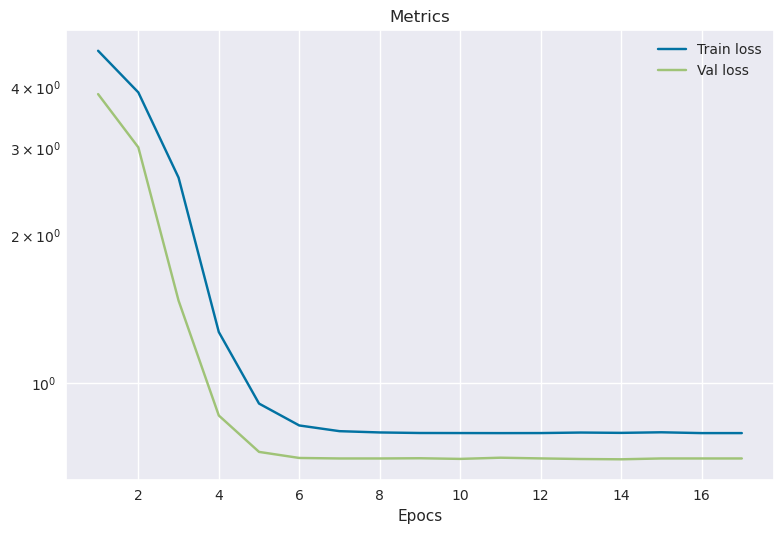

In [20]:
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = ml.MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics       = { 'val_loss': ml.MSELossFn(float_result=True)},
            each_n_epochs = 1
        ),
        ReduceLROnPlateau(
            metric   = 'val_loss',
            mode     = 'min',
            factor   = params.lr_factor,
            patience = params.lr_patience
        ),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        MetricsPlotter(
            metrics            = ['train_loss', 'val_loss'],
            plot_each_n_epochs = 5,
            warmup_count       = 2
        ),
        # SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='stacking')
    ]
)

In [21]:
def evaluate(model, dl):
    predictions = model.evaluate(dl)
    return predictions[0].flatten(), predictions[1]

r2score = R2Score()

In [22]:
train_pred, train_target = evaluate(model, train_dl)
test_pred, test_target   = evaluate(model, test_dl)

r2score(train_pred, train_target), r2score(test_pred, test_target)

(tensor(0.2605), tensor(0.2216))

In [23]:
n_classes = len(train_df.rating.unique())

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),
        mt.MeanNdcgAtk            (k=5),
        mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
    ],
    predictors = [ml.ModulePredictor(model)],
    y_pred_transform_fn = lambda it: it.squeeze(1),
    y_true_transform_fn = lambda it: it
)

summary = validator.validate(test_ds)
summary.save(METRICS_PATH)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

Ordered by mAP@5(4,5):


,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
Stacking,249.5,0.836797,0.966088,0.428534,0.697645,0.697481,0.697417


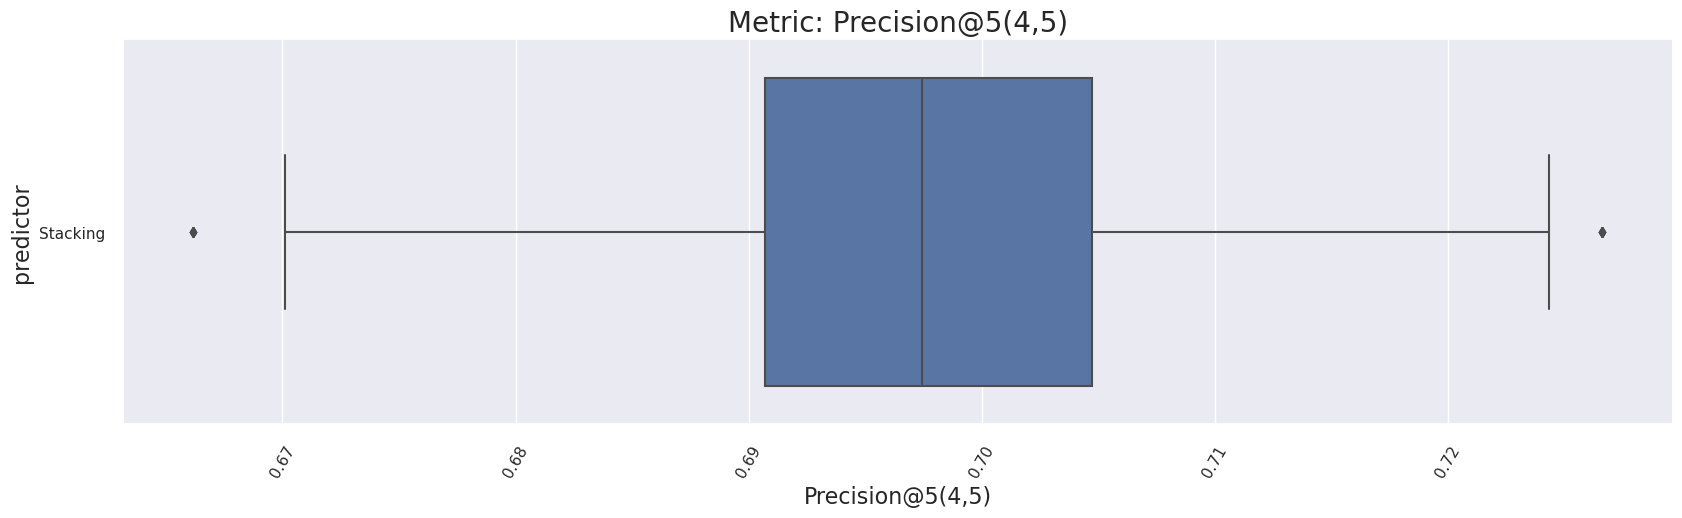

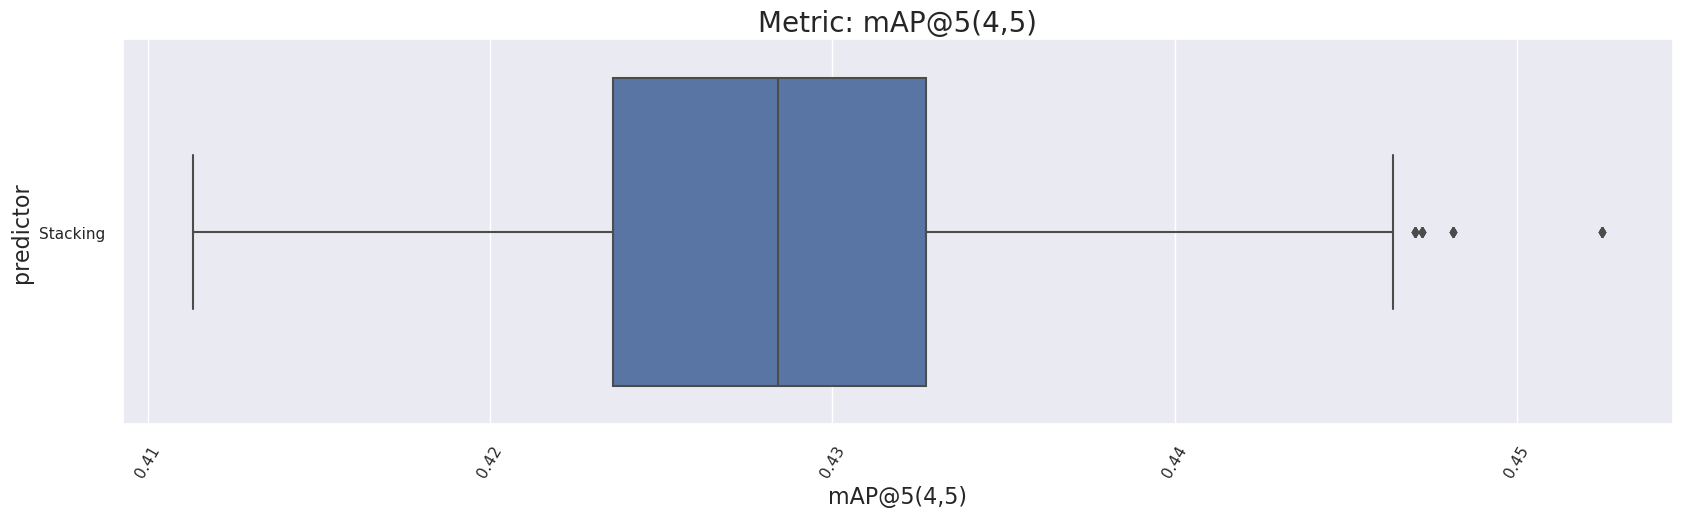

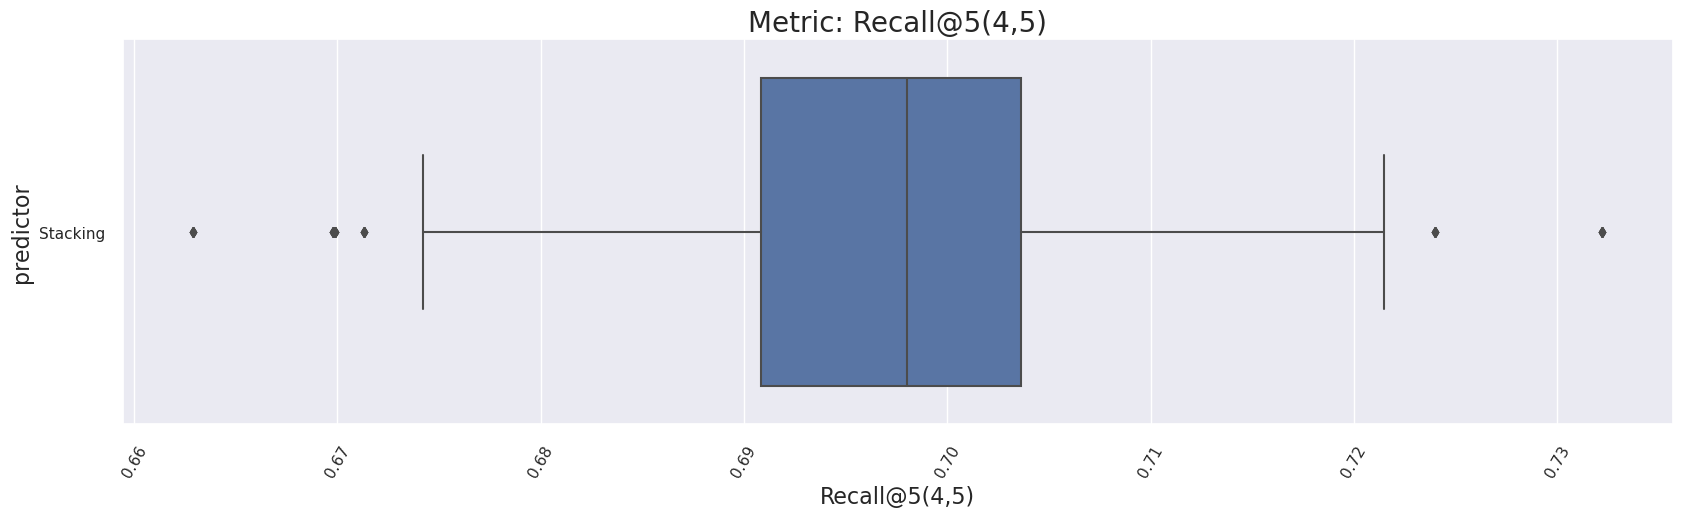

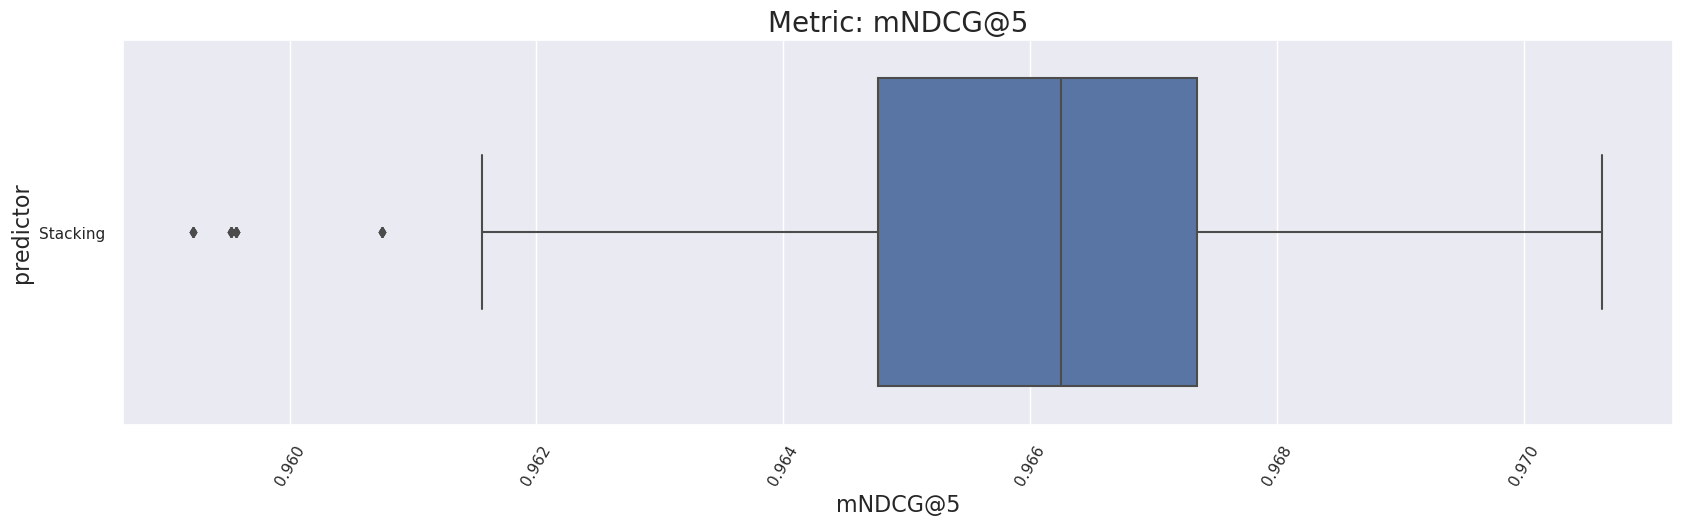

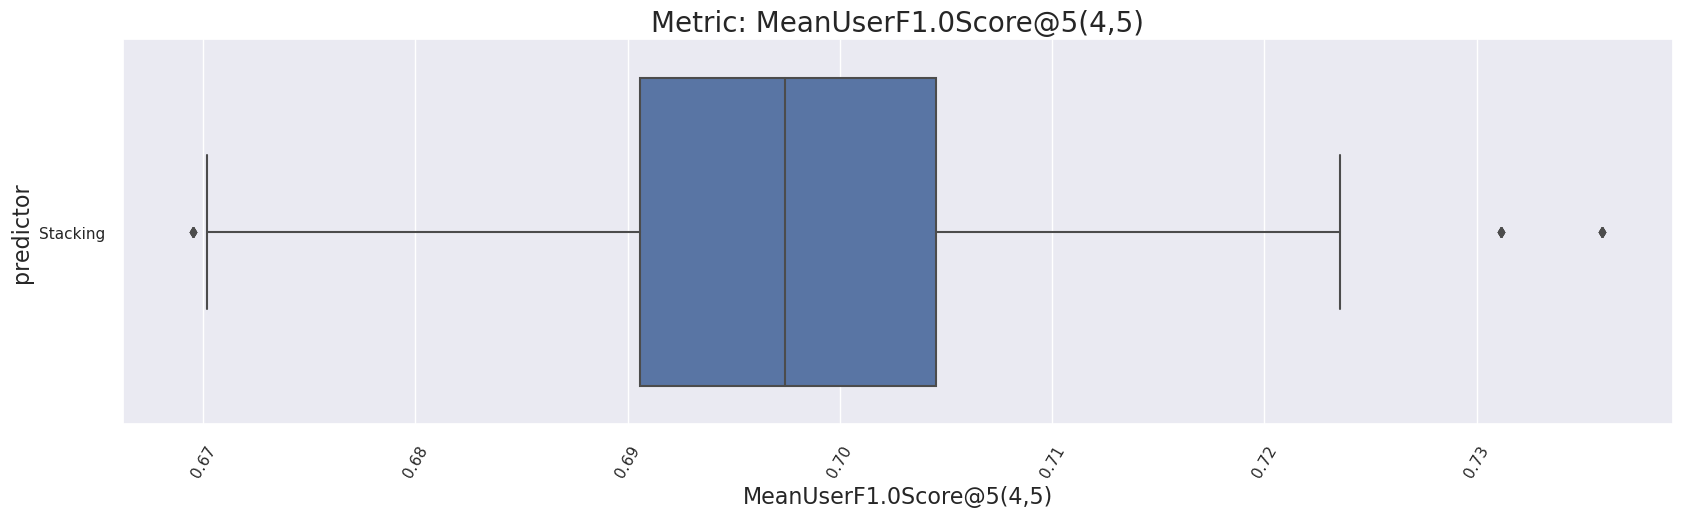

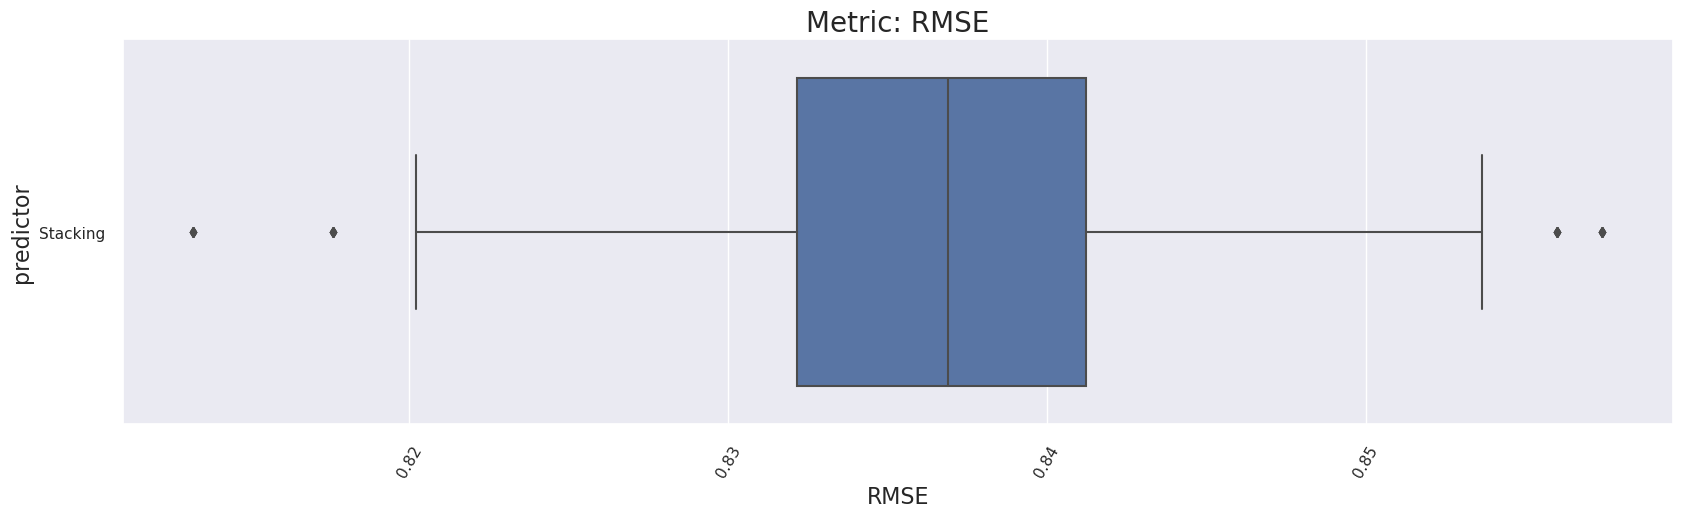

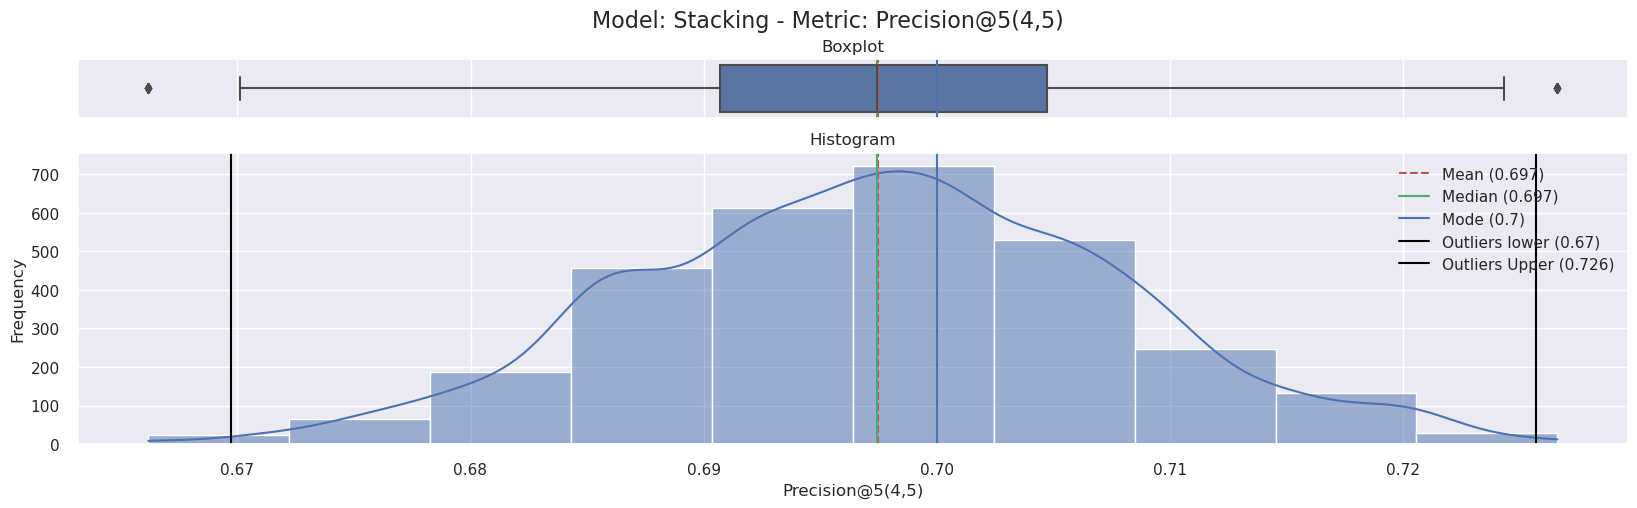

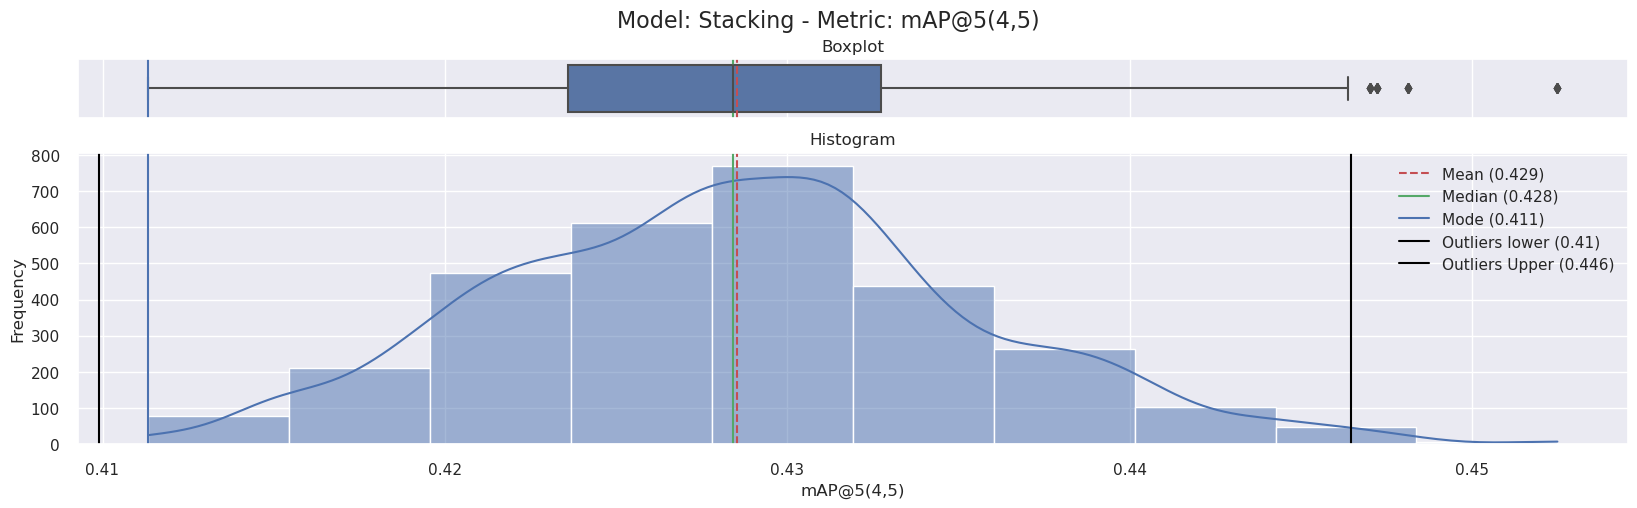

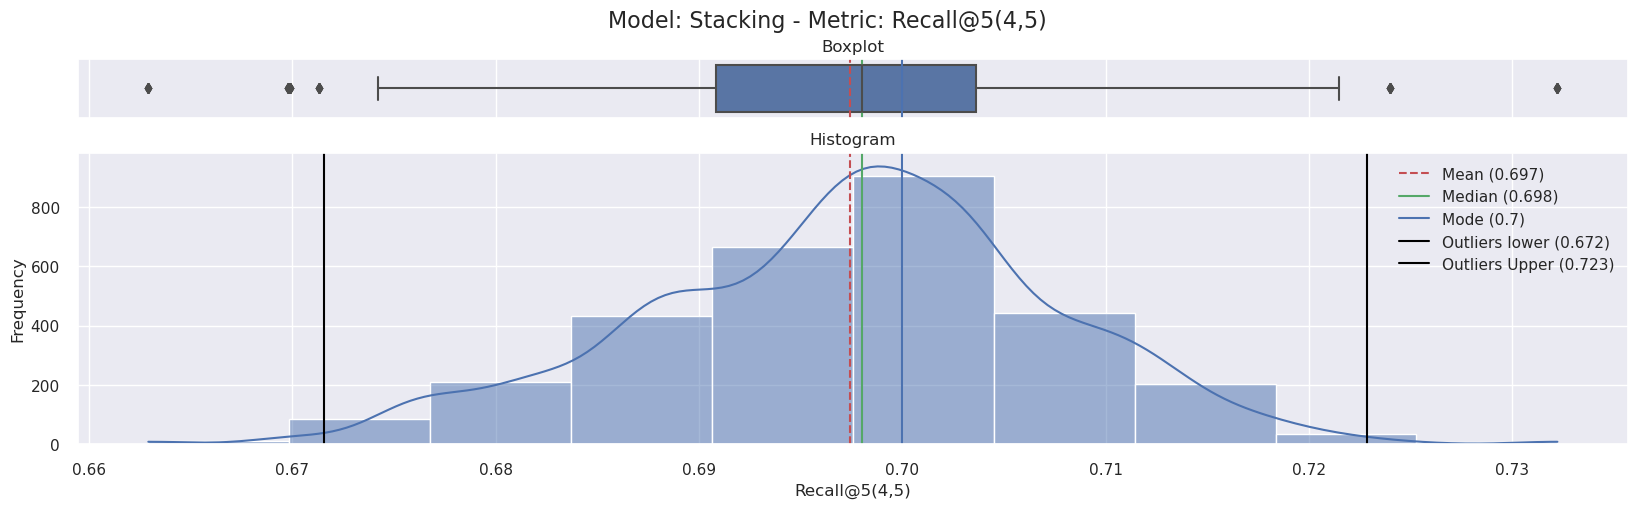

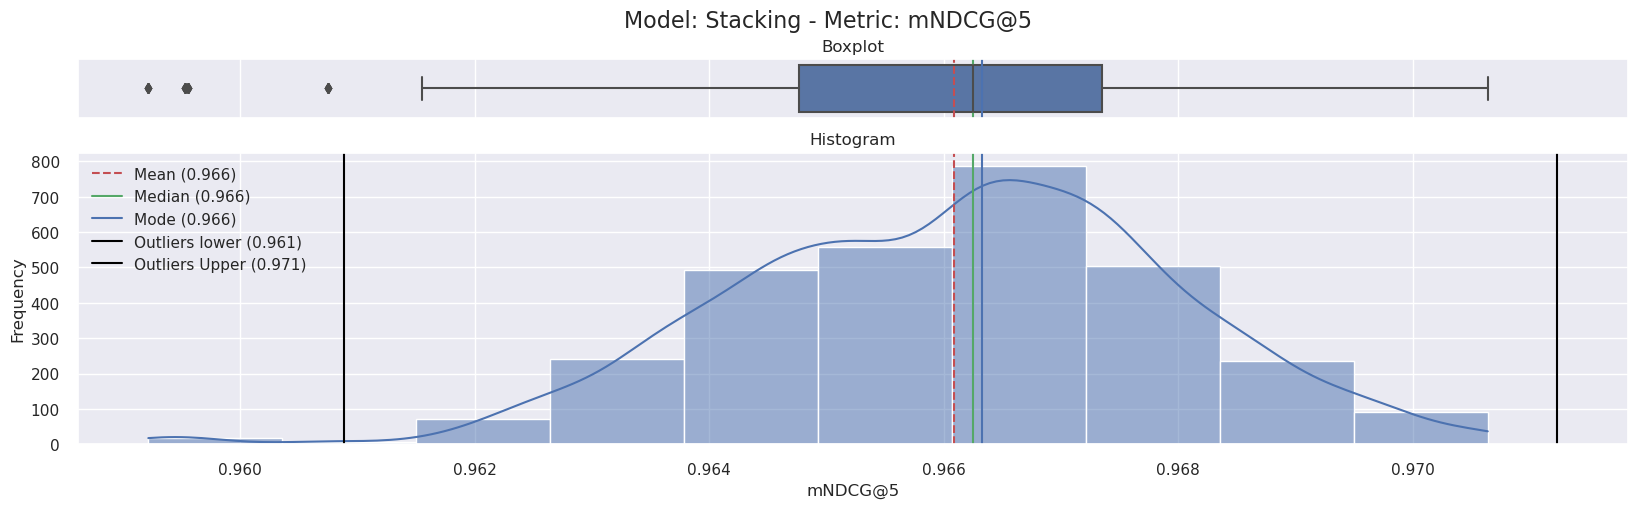

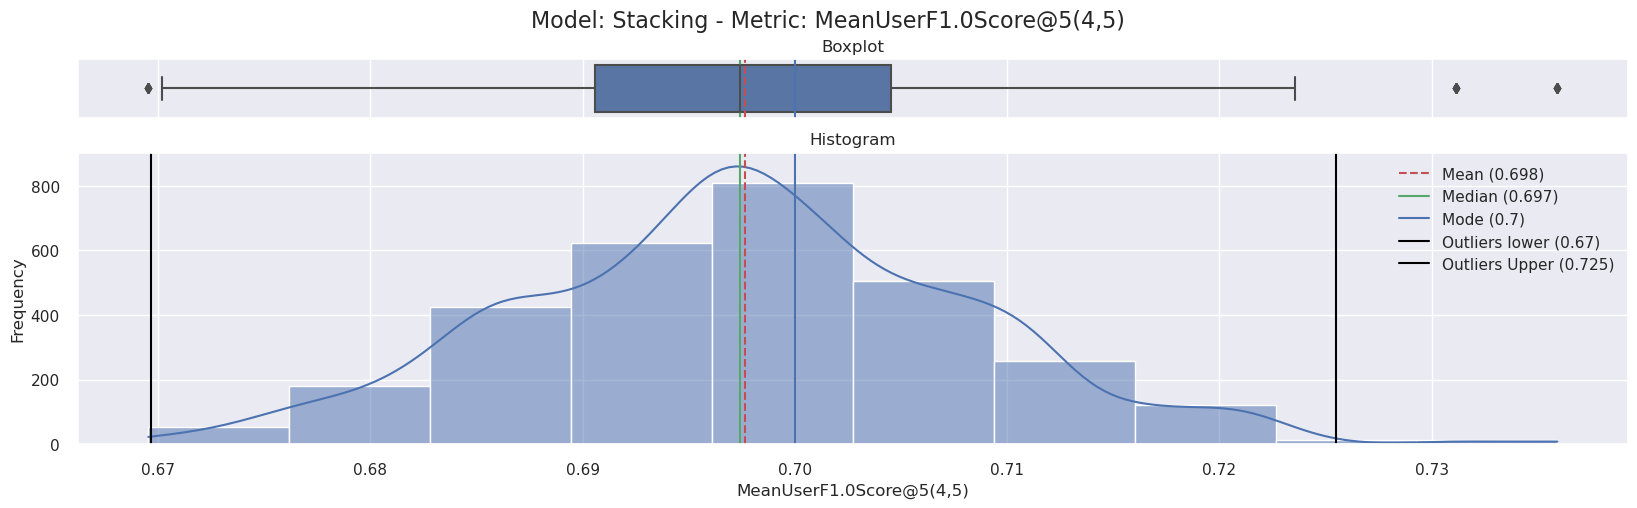

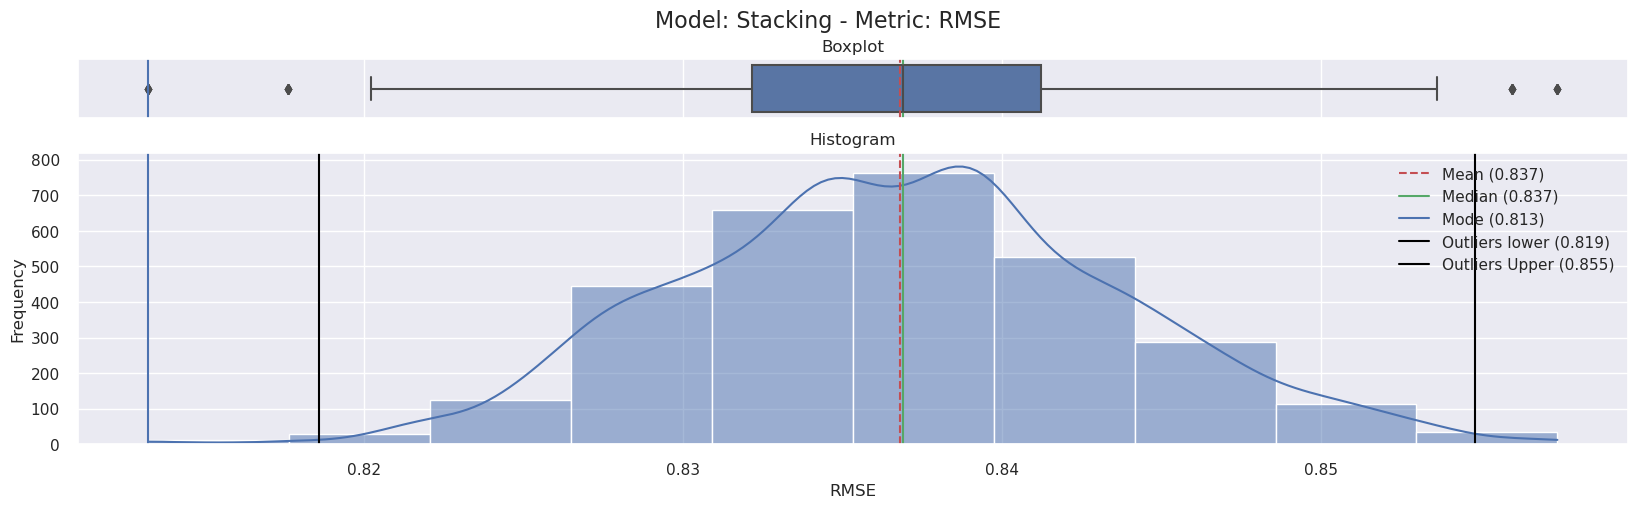

In [25]:
summary.plot()